# Test of Doppler lags for the observed oscillations

Following tests are scripted for comprehensive characterization
- convergence to reference orbit with zero lags
- impact of a uniform lag in the Doppler (range rate) data
- impact of light-time lags, i.e., radial acceleration and light time
- impact of light-time lags times a scale factor


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 5*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris

from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray

import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
    except ValueError:
        # no swings identified
        pass

def fitv(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_doppler_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'doppler (m/s)')
    return fitter

def reusefitv(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.doppler_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'doppler (m/s)')
    return residual

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value

near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")

near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-01-28 08:53:55.600 [ 120 ]

::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 3036239.0077683222 km
Start and end radial speeds: 7.3216176182785535 km / s 6.784349119880077 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.4576006592003391 deg


In [5]:
vdata_ref = []
vlags = []
vlags_full = []
vdata_constvlags = []
vdata_ltlags_full = []
vdata_ltlags = []
vdata_scaledlags = []

scalefactor = 0.1
first_vlag = None

for e in epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss34.range_rate_accel(near_extended_ephem, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_ra.to_value(u.m/(u.s*u.s)),
         ref_rs.to_value(u.m/(u.s*u.s)),
         (ref_ra+ref_rs).to_value(u.m/(u.s*u.s)),
         )

    vlag_full = ref_ra*ref_r/const.c
    vlag = (ref_ra+ref_rs)*ref_r/const.c

    if first_vlag is None:
        first_vlag = vlag

    vlags.append(vlag)
    vlags_full.append(vlag_full)

    vdata_ref.append([ref_rr])
    vdata_constvlags.append([ref_rr - first_vlag])
    vdata_ltlags_full.append([ref_rr - vlag_full])
    vdata_ltlags.append([ref_rr - vlag])
    vdata_scaledlags.append([ref_rr - scalefactor*vlag])

09:53:55 73145.82143191747 -0.04185589375538257 0.01192843359500273 -0.029927460160379837
10:53:55 99245.7532096098 -0.03059583885089978 0.00693192085350347 -0.02366391799739631
11:53:55 124953.15770282669 -0.019042220756659844 0.003217205848670801 -0.015825014907989043
12:53:55 150407.26865298714 -0.011860758101001068 2.649666981824339e-06 -0.011858108434019243
13:53:55 175706.3273609694 -0.0061811455198679255 -0.002839522583883536 -0.009020668103751461
14:53:55 200923.61747138412 -0.0019067205281331212 -0.0052638765777146546 -0.007170597105847777
15:53:55 226115.081514972 0.0013292310754309256 -0.00718074742607655 -0.005851516350645625
16:53:55 251322.7147374973 0.0036045875928536475 -0.008504513680904324 -0.004899926088050678
17:53:55 276576.09410904173 0.004988653794057996 -0.00917620543836506 -0.004187551644307065
18:53:55 301893.2139723953 0.005533782702293877 -0.009174524770680037 -0.003640742068386161
19:53:55 327281.2187505763 0.005310967222449392 -0.008520129656403697 -0.0032

02:53:55 2294074.954473082 -0.006125892132224919 0.006045669772674955 -8.02223595499641e-05
03:53:55 2319085.285435454 -0.007502706117712421 0.007423510010596601 -7.919610711581946e-05
04:53:55 2343998.9351332914 -0.008370346860964162 0.00829252744477671 -7.78194161874514e-05
05:53:55 2368804.7220748416 -0.008669658825510851 0.008593571250424648 -7.60875750862029e-05
06:53:55 2393498.7882963875 -0.008380192023871302 0.008306172101434584 -7.401992243671802e-05
07:53:55 2418084.8629738037 -0.007521577447100469 0.007449916717192195 -7.166072990827411e-05
08:53:55 2442574.0094743236 -0.006152236402101607 0.006083158292796043 -6.90781093055646e-05
09:53:55 2466983.8724922636 -0.004365494502778233 0.0042991340695266445 -6.636043325158896e-05
10:53:55 2491337.475376138 -0.0022833321571269494 0.0022197221042432602 -6.361005288368931e-05
11:53:55 2515661.648220473 -4.8158355525629304e-05 -1.277645012009998e-05 -6.0934805645729284e-05
12:53:55 2539985.1927569434 0.002186865988740294 -0.002245304

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 119
    # variables        = 6
    chi-square         = 2.7768e-22
    reduced chi-square = 2.4573e-24
    Akaike info crit   = -6463.34928
    Bayesian info crit = -6446.67454
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83942476 (init = -1.839425)
    raan:  1.54005925 (init = 1.540059)
    argp:  2.53325839 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:05.280598

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 690

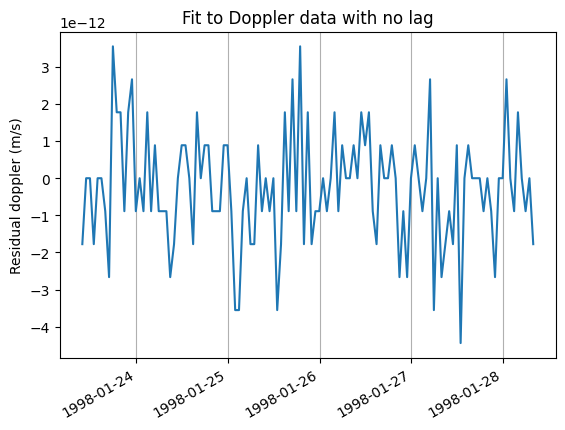

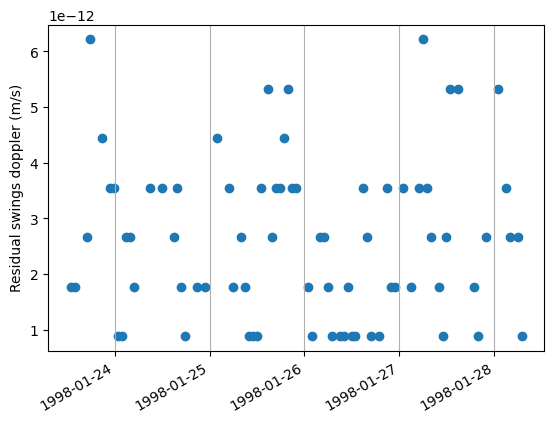

In [6]:
fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ref, "Fit to Doppler data with no lag")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 119
    # variables        = 6
    chi-square         = 0.00543644
    reduced chi-square = 4.8110e-05
    Akaike info crit   = -1177.25666
    Bayesian info crit = -1160.58192
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83948553 (init = -1.839425)
    raan:  1.53989514 (init = 1.540059)
    argp:  2.53320697 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:08.685079

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.003627240720227576, 0.003446302

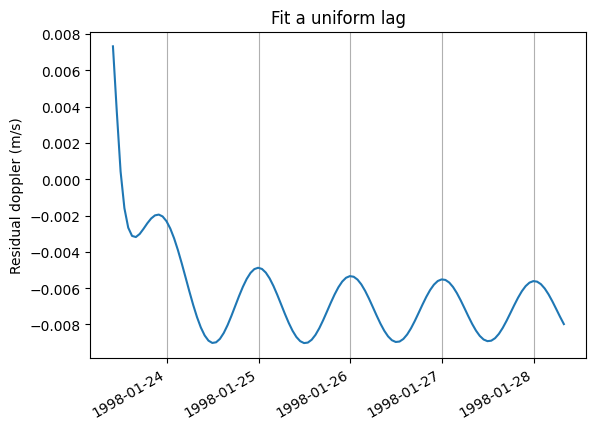

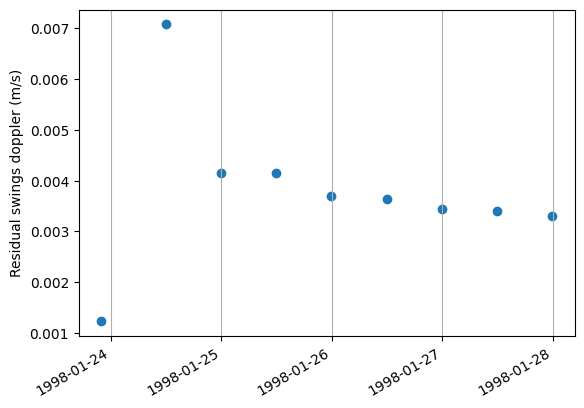

In [7]:
constfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_constvlags, "Fit a uniform lag")

[0.003627240720227576, 0.003446302728526973, 0.003400628550309648, 0.0033060573141341365]


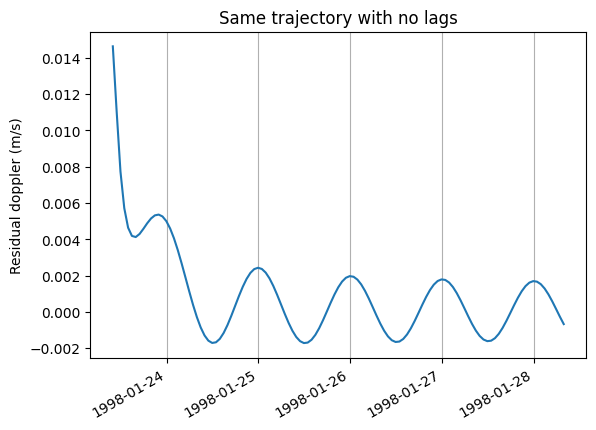

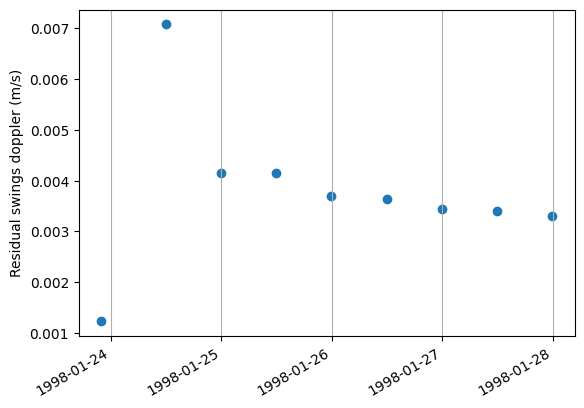

In [8]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ref, "Same trajectory with no lags")

[0.003472324066500221, 0.0035092642560741183, 0.0033083095427599574, 0.0033399012142609763]


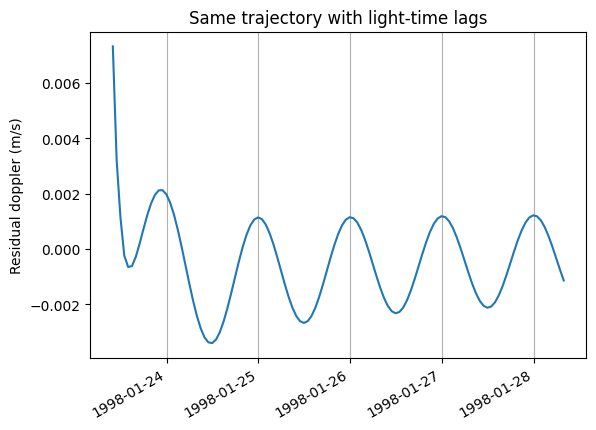

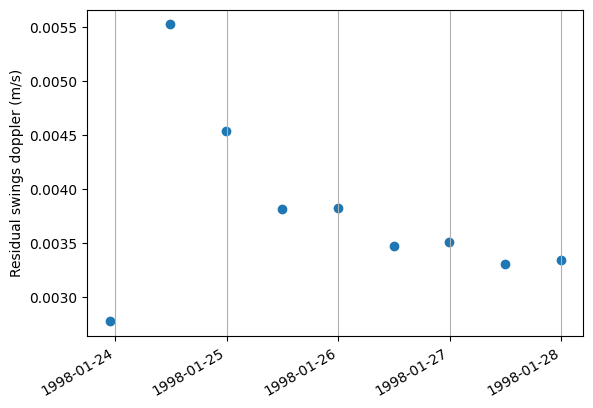

In [9]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ltlags, "Same trajectory with light-time lags")

[0.11022779438629726, 0.12708119513771265, 0.14416144829798583, 0.16103284675850205]


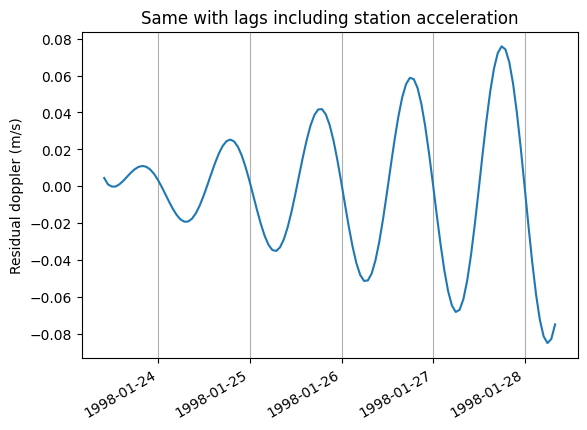

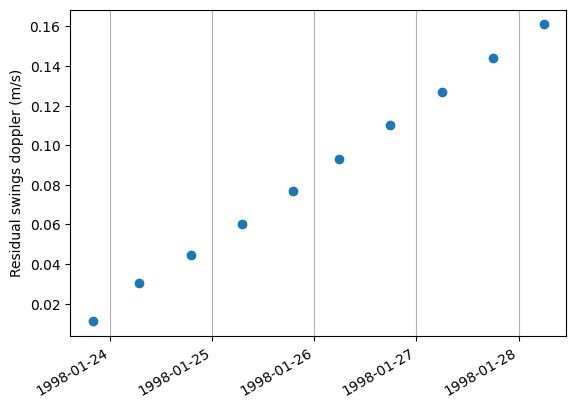

In [10]:
_ = reusefitv(constfitv, epochs[:-1], vdata_ltlags_full, "Same with lags including station acceleration")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 119
    # variables        = 6
    chi-square         = 1.4756e-04
    reduced chi-square = 1.3058e-06
    Akaike info crit   = -1606.44799
    Bayesian info crit = -1589.77325
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945736 (init = -1.839425)
    raan:  1.54000415 (init = 1.540059)
    argp:  2.53324142 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:08.647573

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.001

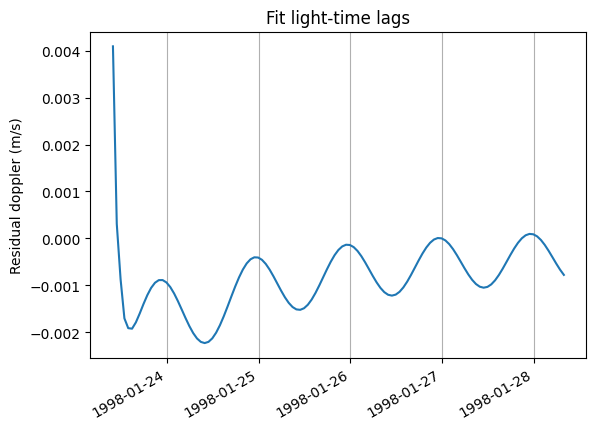

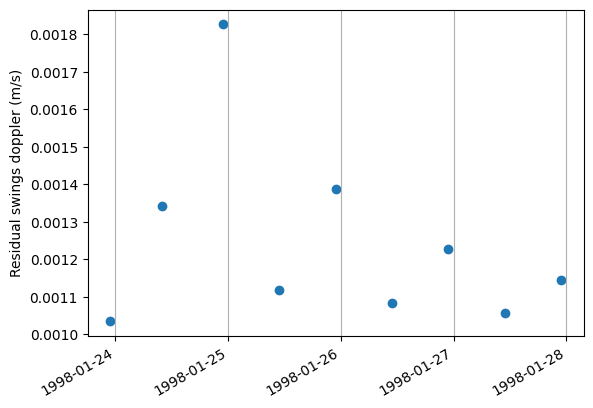

In [11]:
ltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags, "Fit light-time lags")

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 119
    # variables        = 6
    chi-square         = 1.4755e-06
    reduced chi-square = 1.3058e-08
    Akaike info crit   = -2154.46811
    Bayesian info crit = -2137.79337
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    nu:    at initial value
    raan:  at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83942802 (init = -1.839425)
    raan:  1.54005374 (init = 1.540059)
    argp:  2.53325669 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:08.400387

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 69

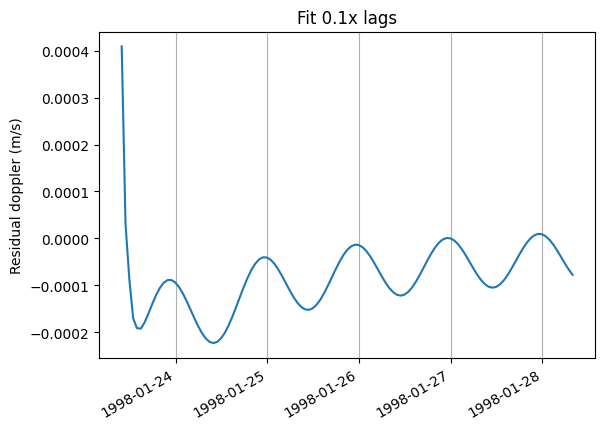

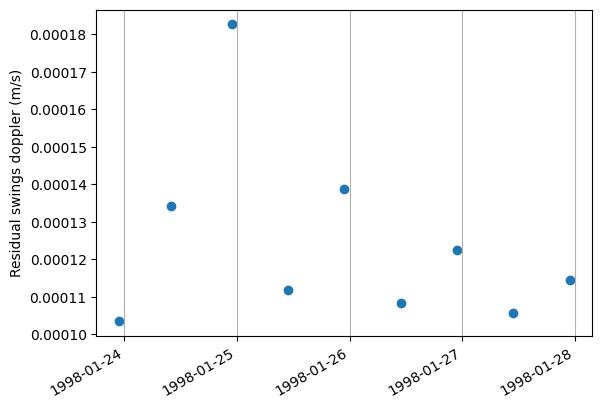

In [12]:
scaledfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_scaledlags, f'Fit {scalefactor}x lags')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 119
    # variables        = 6
    chi-square         = 0.03755552
    reduced chi-square = 3.3235e-04
    Akaike info crit   = -947.265945
    Bayesian info crit = -930.591204
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83948696 (init = -1.839425)
    raan:  1.53991655 (init = 1.540059)
    argp:  2.53309436 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:10.270808

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.02594540465494788, 0.0402223505

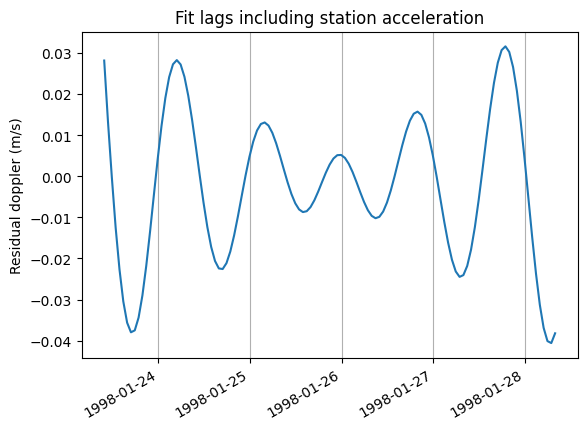

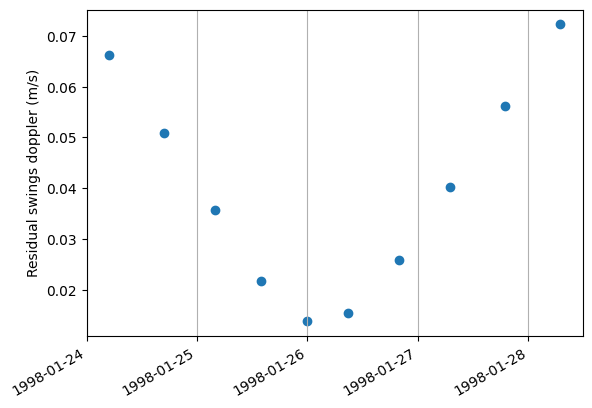

In [13]:
fltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags_full, "Fit lags including station acceleration")

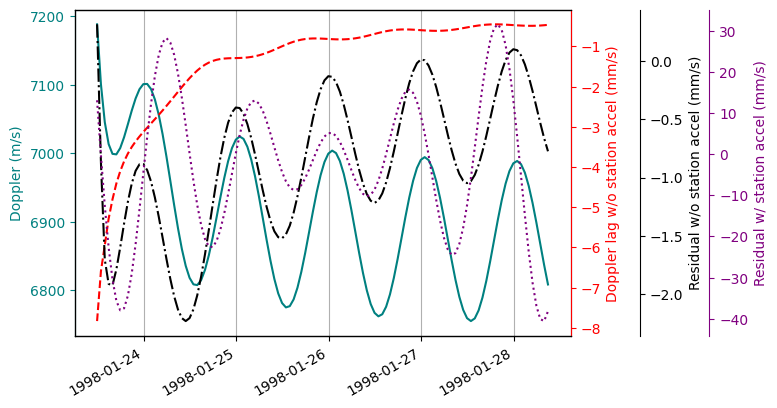

In [20]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Doppler (m/s)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")

    ax2 = ax.twinx()
    ax2.set_ylabel('Doppler lag w/o station accel (mm/s)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residual w/o station accel (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))

    ax4 = ax.twinx()
    ax4.set_ylabel('Residual w/ station accel (mm/s)', color = "purple")
    ax4.spines['right'].set(position=('outward', 100), color = "purple")
    ax4.tick_params(axis="y", colors="purple")

    #h1 = ax4.axhline(y = 929, linestyle = "dashed", color='black', label="Earth SOI")
    #h2 = ax4.axhline(y = 384.4, linestyle = "dotted", color='black', label="Distance to moon")

    p1, = ax.plot(epochs[2:], [v[0].to_value(u.m/u.s) for v in vdata_ref[1:]],
                  color="teal", label="Doppler")
    p2, = ax2.plot(epochs[2:], [v.to_value(u.mm/u.s) for v in vlags[1:]],
                   linestyle = "dashed", color="red", label="lag w/o station accel")

    p3, = ax3.plot(epochs[2:], [1e3*v for v in ltfitv.result.residual[1:]],
                   linestyle='-.', color="black", label="residual w/o station accel")
    p4, = ax4.plot(epochs[2:], [1e3*v for v in fltfitv.result.residual[1:]],
                   linestyle=":", color="purple", label="residual")

    #ax.legend(handles=[p1, p4, p2, p3], loc="lower right", ncol=2)
    plt.gcf().autofmt_xdate()

    plt.savefig(f'near_sim_postencounter_doppler-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')